In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from __future__ import division

import numpy as np
import os
#import mne
import pandas as pd
import matplotlib.pyplot as plt

from scipy import io, signal

from data_utils import *
from preprocessing import *
from models import *
from metrics import *
from plotting import *

from sklearn.linear_model import LogisticRegression as LR
from sklearn import svm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score

import mtspec
import spectrum

no cv2... continuing...


Using Theano backend.
Using gpu device 0: Tesla K20c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [69]:
# X_s, Y_s, Y_l, ch_dict = import_data(-1, downsample=5, filt=None,#'CAR',
#                                      ch_dict=True, bp_range=None)#(0.5,40))

X_s, Y_s, Y_l, ch_dict = import_data(-1, downsample=5, filt='CAR',
                                     ch_dict=True, bp_range=(0.5,40))

no cv2... continuing...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
inconsistent number of epochs and labels:                        
	 expected:132 have:132


In [26]:
#
ch = 12 # FC6
x_sig = X_s[0][:,ch]

Xbp = bp_filter(X_s[0],fs=200,low=.5,high=40)
Xcar = Xbp - Xbp.mean(1)[:,None]

xbp,xcar = Xbp[:,ch], Xcar[:,ch]

Xcar2 = bp_filter(X_s[0]-X_s[0].mean(1)[:,None],fs=200,low=.5,high=40)
xcar2 = Xcar2[:,ch]

t0, tf = 10,30
t = np.linspace(t0, tf, 200*(tf-t0))
mapper = lambda s: s[(t*200).astype(int)]
x, xcar, xbp, xcar2, y = map(mapper, [x_sig, xcar, xbp, xcar2, Y_s[0]])



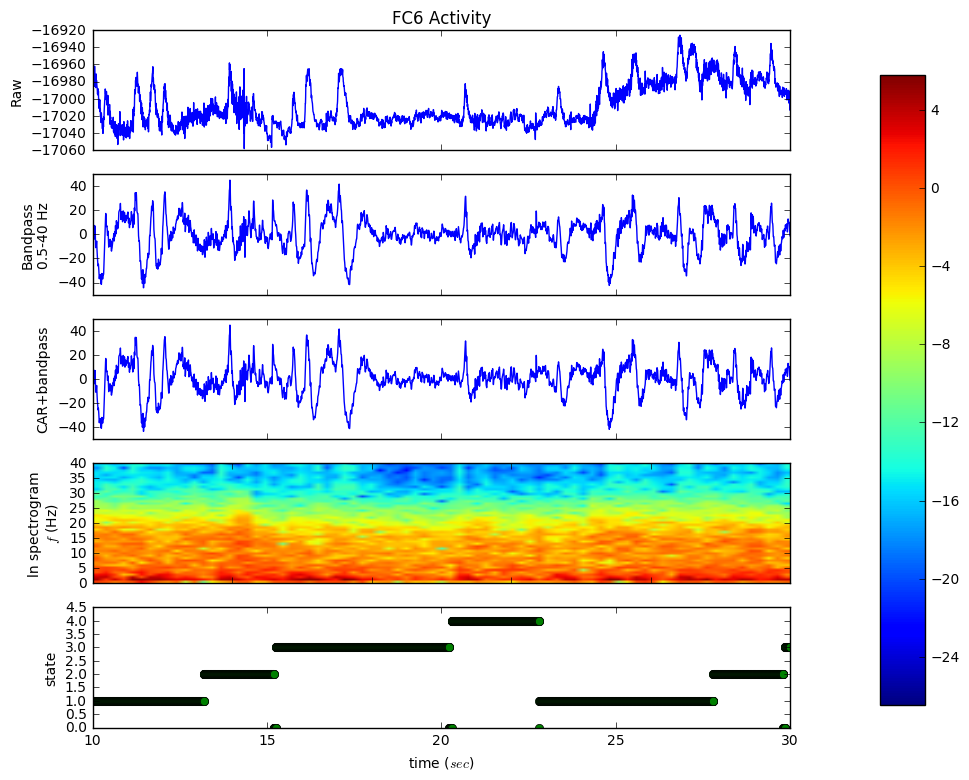

In [68]:
fig = plt.figure(figsize=(9,9))
plt.title("FC6 Activity")

def clear():
    for frame in plt.gca().axes.get_xticklabels():
        frame.set_visible(False)

N=5

plt.subplot(N,1,1)
plt.title("FC6 Activity")
plt.plot(t, x)
plt.ylabel('Raw')
for frame in plt.gca().axes.get_xticklabels():
    frame.set_visible(False)

plt.subplot(N,1,2)
plt.plot(t, xbp)
plt.ylabel("Bandpass\n0.5-40 Hz")
clear()


plt.subplot(N,1,3)
plt.plot(t, xcar2)
plt.ylabel("CAR+bandpass")
clear()

plt.subplot(N,1,4)
#
tt, f, S = signal.spectrogram(xcar2, fs=200, nperseg=100, noverlap=50)
Sx = S[:,(f<=40)]
im = plt.imshow(np.log(Sx), aspect='auto', origin='lower',
           extent=[tt.min(), tt.max(), 0, 40])
#plt.colorbar(im, ax=ax)
#
#plt.specgram(x, Fs=200, NFFT=100, noverlap=50, detrend=None, mode='psd')
#
plt.ylabel('ln spectrogram\n$f$ (Hz)')
clear()

plt.subplot(N,1,5)
plt.plot(t, y, 'go')
plt.ylabel("state")
plt.ylim([0, 4.5])

plt.xlabel("time ($sec$)")

cbar_ax = fig.add_axes([1.00, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


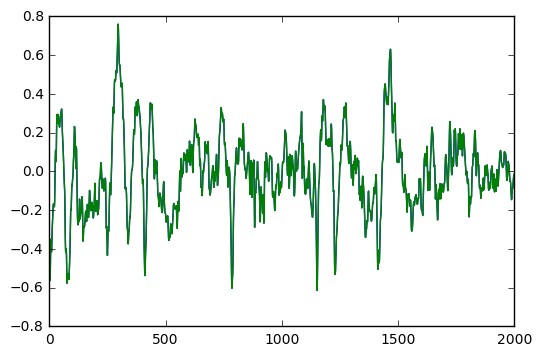

In [14]:
plt.figure()

plt.subplot(2,1,1)
plt.plot()

plt.subplot(2,1,2)
plt.plot(xcar2-xbp)

In [ ]:
# plot some signals 
data = X_s[0]

numRows = 4

dmin = data.min()
dmax = data.max()
dr = (dmax - dmin)*0.7  # Crowd them a bit.
y0 = dmin
y1 = (numRows - 1) * dr + dmax
ylim(y0, y1)

segs = []
for i in range(numRows):
    segs.append(np.hstack((t[:, np.newaxis], data[:, i, np.newaxis])))
    ticklocs.append(i*dr)

offsets = np.zeros((numRows, 2), dtype=float)
offsets[:, 1] = ticklocs

lines = plt.LineCollection(segs, offsets=offsets,
                       transOffset=None,
                       )

ax, fig = plt.figure()
ax.add_collection(lines)

In [ ]:
ch_ls = []
for key,value in sorted(ch_dict.items(), key=lambda x: x[1]):
    print key,value,'\t',
    ch_ls.append(key)

In [ ]:
x = X_s[0][:10000,0]

In [ ]:
X = X_s[0]
T = 10000

for i in range(10):
    plt.subplot(10,1,i+1)
    plt.plot(X[:T,i])
    

In [ ]:
plt.plot(np.arange(10000)/200,X[10000:20000, 0])

In [ ]:
nu = np.random.rand(1000)
fnu = bp_filter(nu, .5, 40, fs=200)


plt.subplot(2,1,1)
plt.plot(nu)
plt.plot(fnu)

plt.subplot(2,1,2)
plt.plot(*signal.welch(nu, fs=200))
plt.plot(*signal.welch(fnu, fs=200))



In [ ]:
f,P = signal.welch(X[10000:20000, 2], fs=200)

fm = 10
plt.plot(f[fm:], P[fm:])

In [ ]:
# state vs rest
subj = 0
X, Y = X_s[subj], Y_s[subj]

if raw_input('use channel filter? ').lower() == 'yes':
    X = X[:,ch_filter]
#Y = narrow(Y, 4, .2, 1)

# if False:
#     channs = 'FC6 FT8 C4 T7 C5 C3 CP5 CP3 CP1 P3'.split()
#     channs = map(lambda ch: ch_dict[ch], channs)
#     X = X[:, channs]
# elif False:
#     channs = range(64)
#     channs.remove(32)
#     channs.remove(42) #remove m1, m2
#     X = X[:, channs]
# elif False:
#     X = X[:,67][:,None]
# print "number of channels used:", X.shape[1]

# fs = 200
# window_size = 2000
# window_stride = 500
# num_wins = 5
# # choose labels to compare
# label = 3
# rest = 1

# # locate labels
# Y_1 = (Y == label).astype(int)
# Y_0 = (Y == rest).astype(int)
# diff0, diff1 = np.diff(Y_0), np.diff(Y_1)
# # compute window limits
# start0, end0 = map(lambda x: np.where(x)[0], [diff0>0, diff0<0])
# start1, end1 = map(lambda x: np.where(x)[0], [diff1>0, diff1<0])

# mapper = lambda lims: X[lims[0]:lims[1]]
# X0, X1 = rec_map(mapper, [zip(start0, end0), zip(start1, end1)], 2)
# # window series
# mapper = lambda win: window_series(win, width=window_size, 
#                                    stride=window_stride, fs=fs, num_wins=num_wins)
# X0, X1 = rec_map(mapper, [X0, X1], 2)
# # flatten windows
# mapper = lambda x: [i for j in x for i in j]
# X0, X1 = map(mapper, [X0, X1])
# # split data
# X0_train, X0_test = split(X0)
# X1_train, X1_test = split(X1)
# X_train, X_test = map(np.concatenate, [[X0_train, X1_train], [X0_test, X1_test]])
# # create label vectors
# Y0_train, Y0_test = np.zeros(len(X0_train)), np.zeros(len(X0_test))
# Y1_train, Y1_test = np.ones(len(X1_train)), np.ones(len(X1_test))
# Y_train, Y_test = map(np.concatenate, [[Y0_train, Y1_train], [Y0_test, Y1_test]])
# # verify dimensions

(X_train, Y_train), (X_test, Y_test) = state_window(X, Y, num_wins=5)

dim(X_train)
dim(X_test)

print "train:test :", len(X_train), len(X_test)



(X3_train, Y3_train), (X3_test, Y3_test) = (X_train, Y_train), (X_test, Y_test)

bal = True
if bal:
    (X3_train, Y3_train), (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))
    #_, (X3_test, Y3_test) = map(balance, (X3_train, X3_test), (Y3_train, Y3_test))

print "ratio of true:false : ", sum(list(Y3_train) + list(Y3_test))/(len(Y3_train)+len(Y3_test))
print "N train:{} N test:{}".format(len(X3_train),len(X3_test))
#mapper = lambda wins: feature_vect(wins, 5, norm=True)

ftype = 1
norm = True


X3_train, means, stds = feature_vect(X3_train, ftype, trim=False, norm=norm)
X3_test, _, _ = feature_vect(X3_test, ftype, trim=False, norm=norm)

In [ ]:
# model fit
if False:
    mapper = lambda x: x[mu_keeps]
    X3_train, X3_test = rec_map(mapper, [X3_train, X3_test], 2)

X_tr, Y_tr = X3_train, Y3_train
X_ts, Y_ts = X3_test, Y3_test

mtype = 'LR'
if mtype == 'LR':
    model = LR(n_jobs=-1)
elif mtype == 'SVM':
    model = svm.SVC(cache_size=1000)
elif mtype == 'linSVM':
    model = svm.LinearSVC()

print "number of features:", len(X3_train[0])

model.fit(np.asarray(X_tr), np.asarray(Y_tr))

Y_pr = model.predict(np.asarray(X_ts))
yy = model.predict(np.asarray(X_tr))
print "fit"
metrics(Y_tr, yy)
print "predict"
metrics(Y_ts, Y_pr)

In [ ]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import 

def create_mlp(input_len, output_len):

    model = Sequential()
    
    model.add(Dense(50, input_shape=(input_len,), activation='tanh'))
    model.add(Dense(output_len, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(),
                 metrics = ['accuracy'])

    return model


def create_lr(input_len, output_len, reg=True):

    model = Sequential()
    
    model.add(Dense(output_len, input_dim=input_len, 
                    activation='softmax'))
    
    if reg:
        

    model.compile(loss='mse',
                  optimizer='adam',
                 metrics = ['accuracy'])

    return model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

# Do all subjects

In [119]:
#do all subjects

Y_pairs = []
tick = 0

model_type = 'LR'

dP = []
rP = []
XY = []

target = 4

for X, Y in zip(X_s,Y_s):
    # window
    (X_train, Y_train), (X_test, Y_test) = state_window(X, Y, 
                                                    label=target, num_wins=1)
    # balance
    #(X_train, Y_train), (X_test, Y_test) = map(balance, 
    #                                           (X_train, X_test), 
    #                                           (Y_train, Y_test))
    # map features
    #mapper = lambda win: np.concatenate([psd(win, 'welch').flatten(), np.log(psd(win, 'welch').flatten())]).flatten()
    mapper = lambda win: np.log(psd(win, 'welch').flatten()).flatten()
    X_train, X_test = rec_map(mapper, [X_train, X_test])
    # log
    if False:
        mapper = lambda win: np.log(win)
        X_train, X_test = rec_map(mapper, [X_train, X_test])
    #
    X_train, X_test = map(normalizer, [X_train, X_test])
    # delta for X_train
    X_train, Y_train, X_test, Y_test = map(np.asarray,
                            [X_train, Y_train, X_test, Y_test])
    X1, X0 = X_train[Y_train==1], X_train[Y_train==0]
    x1, x0 = X1.mean(0), X0.mean(0)
    diff = x1-x0
    dP.append(diff)
    #corr coeff
    n = X_train.shape[0]
    shp = X_train.shape[1:]
    Xt = X_train.reshape(n, -1)
    V = np.concatenate((Xt, Y_train[:,None]), axis=1)
    r = np.corrcoef(V, rowvar=0)[-1,:-1]
    rP.append(r.reshape(shp))
    # flatten
    mapper = lambda v: v.reshape(-1)
    X_train, X_test = rec_map(mapper, [X_train, X_test])
    print np.shape(X_train)
    # run through  classifier
    if model_type == 'LR':
        model = LR(n_jobs=-1)#KNN(8)
        model.fit(np.asarray(X_train), np.asarray(Y_train))
        Y_pred = model.predict(np.asarray(X_test))
    elif model_type == 'NN':
        model = create_lr(X_train[0].shape[0], 2)
        model.fit(np.asarray(X_train), to_cat(Y_train),
                  nb_epoch=20,
                  verbose=0)
        Y_pred = model.predict_classes(np.asarray(X_test))
    # store results
    Y_pairs.append((Y_test, Y_pred))
    # print
    #print 'patient {} done'.format(tick)
    tick += 1
    
    
    
    

(197, 1302)
(155, 1302)
(105, 1302)
(140, 1302)
(173, 1302)
(172, 1302)
(175, 1302)
(130, 1302)
(152, 1302)
(171, 1302)
(175, 1302)
(142, 1302)
(171, 1302)


In [120]:
YYs.append(Y_pairs)

([<matplotlib.axis.XTick at 0x7f8263458890>,
 <a list of 14 Text xticklabel objects>)

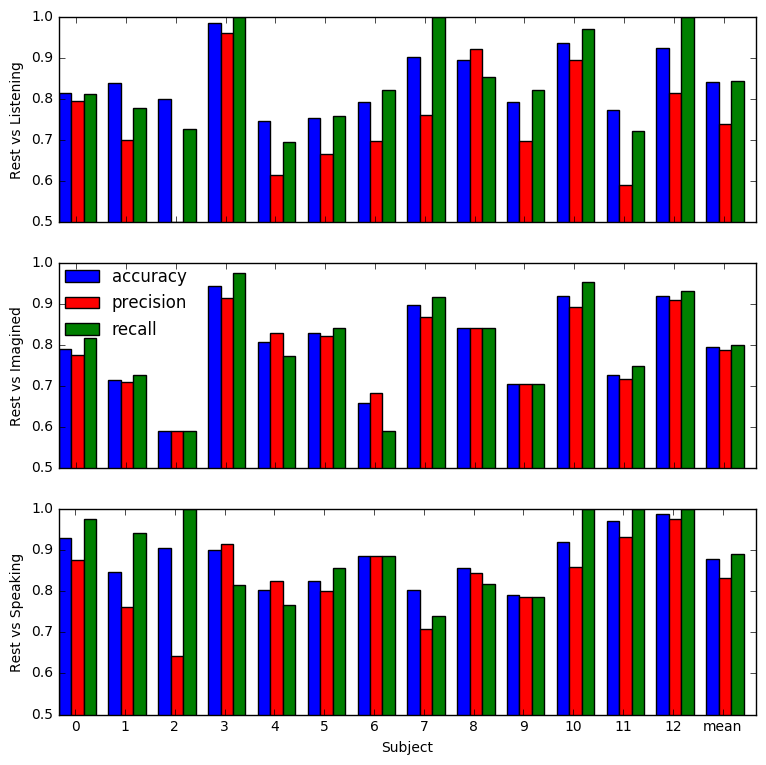

In [141]:
def barplot(Y_pairs):
    accuracy = lambda yy: accuracy_score(yy[0], yy[1])
    precision = lambda yy: precision_score(yy[0], yy[1])
    recall = lambda yy: recall_score(yy[0], yy[1])

    acc = map(accuracy, Y_pairs)
    prec = map(precision, Y_pairs)
    rec = map(recall, Y_pairs)

    mapper = lambda ls: ls+[np.mean(ls)]
    acc, prec, rec = map(mapper, [acc, prec, rec])
    
    subj_num = np.arange(len(acc))

    #plt.figure(figsize=(9,6))


    w = .25
    plt.bar(subj_num, acc, w, color='b', label='accuracy')
    plt.bar(subj_num+w, prec, w, color='r', label='precision')
    plt.bar(subj_num+2*w, rec, w, color='g', label='recall')



    offset = .35
    plt.xticks(subj_num+offset, subj_num)
    plt.ylim([.5, 1])


    #plt.legend(loc='best')

    
fig = plt.figure(1, figsize=(9,9))

plt.subplot(3,1,1)
barplot(YYs[0])
clear()
plt.ylabel("Rest vs Listening")

plt.subplot(3,1,2)
barplot(YYs[1])
plt.ylabel("Rest vs Imagined")
clear()
plt.legend(loc=[0,.6], frameon=False)

plt.subplot(3,1,3)
barplot(YYs[2])
plt.ylabel("Rest vs Speaking")
plt.xlabel("Subject")
plt.xticks(np.arange(14)+.33, range(13)+['mean'])


In [135]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Places a legend on the axes.
    
    To make a legend for lines which already exist on the axes
    (via plot for instance), simply call this function with an iterable
    of strings, one for each legend item. For example::
    
        ax.plot([1, 2, 3])
        ax.legend(['A simple line'])
    
    However, in order to keep the "label" and the legend element
    instance together, it is preferable to specify the label either at
    artist creation, or by calling the
    :meth:`~matplotlib.artist.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        # Overwrite the label by calling the method.
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting with an underscore.
    This is default for all artists, so calling :meth:`leg

In [ ]:
grid_topoplot(rP, scale=.5)

In [ ]:
grid_topoplot(dP, scale=.5)

# COMPARE FEATURES

In [73]:
dim(X_train)

220 62 400 


In [107]:
f_label = ['DWT', 'PSD', 'ln PSD', 'ln(PSD), PSD']
f_id = [3,10,12,13]

ref = 1
target = 3

model_type = 'LR'



YY = []
for f_label_i,f_id_i in zip(f_label, f_id):
    print "running tests using ",f_label_i
    Yp = []
    for X, Y in zip(X_s,Y_s):
        # window
        (X_train, Y_train), (X_test, Y_test) = state_window(X, Y, 
                                                        label=target, num_wins=1)                                         
        # map features
        #mapper = lambda win: np.concatenate([psd(win, 'welch').flatten(), np.log(psd(win, 'welch').flatten())]).flatten()
        mapper = lambda win: feature_vect(win, ftype=f_id_i)
        X_train, X_test = map(mapper, [X_train, X_test])
        # normalize
        X_train, X_test = map(normalizer, [X_train, X_test])
        # run through  classifier
        if model_type == 'LR':
            model = LR(n_jobs=-1)#KNN(8)
            model.fit(np.asarray(X_train), np.asarray(Y_train))
            Y_pred = model.predict(np.asarray(X_test))
        # store results
        Yp.append((Y_test, Y_pred))
    YY.append(Yp)
    

running tests using  DWT
running tests using  PSD
running tests using  ln PSD
running tests using  ln(PSD), PSD


In [78]:
dim(YY)

4 13 2 110 


In [110]:
acc, prec, rec = [],[],[]
for f in YY:
    cache = [[], [], []]
    for s in f:
        cache[0].append(accuracy(s))
        cache[1].append(precision(s))
        cache[2].append(recall(s))
    acc.append(cache[0]+[np.mean(cache[0])])
    prec.append(cache[1]+[np.mean(cache[1])])
    rec.append(cache[2]+[np.mean(cache[2])])
        

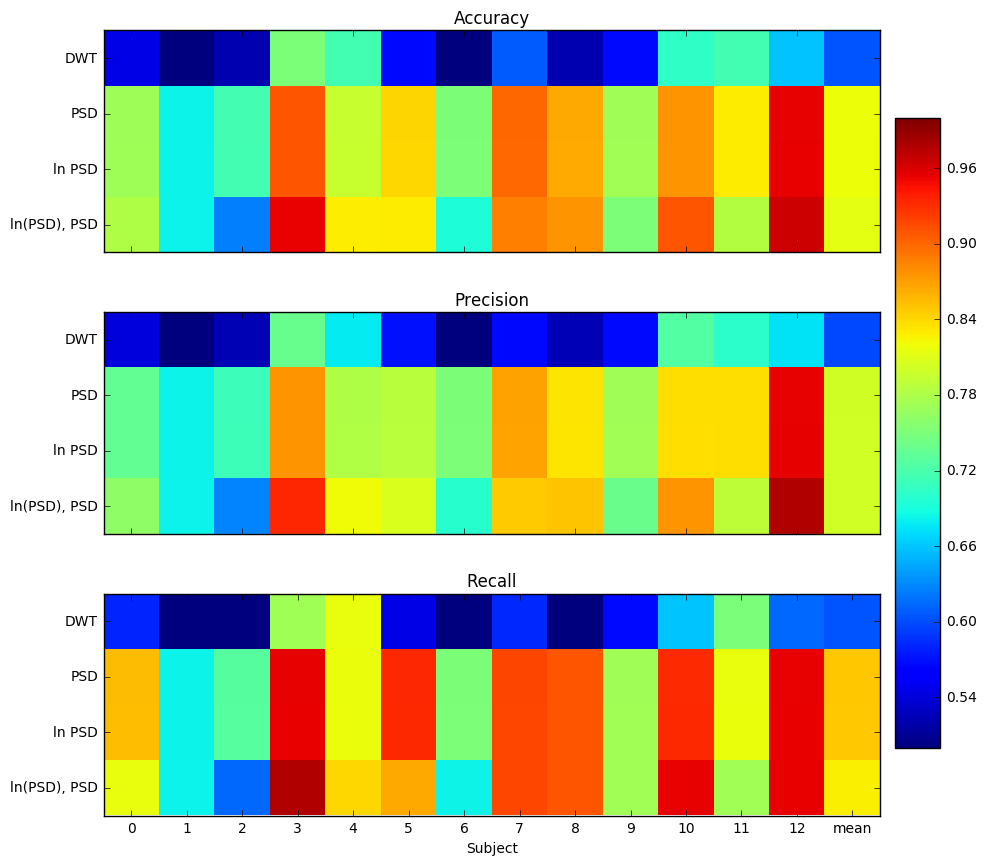

In [112]:
fig = plt.figure(figsize=(9,9))

plt.subplot(3,1,1)
plt.imshow(np.array(acc), interpolation='none', vmin=.5, vmax=1)
plt.yticks(range(4), f_label)
#plt.colorbar()
plt.title("Accuracy")
clear()

plt.subplot(3,1,2)
plt.imshow(np.array(prec), interpolation='none', vmin=.5, vmax=1)
plt.yticks(range(4), f_label)
#plt.colorbar()
plt.title("Precision")
clear()

plt.subplot(3,1,3)
im = plt.imshow(np.array(rec), interpolation='none', vmin=.5, vmax=1)
plt.title("Recall")
plt.yticks(range(4), f_label)
plt.xticks(range(14), range(13)+['mean'])
plt.xlabel("Subject")

plt.tight_layout()

cbar_ax = fig.add_axes([1.00, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)



In [99]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, hold=None, data=None, **kwargs)
    Display an image on the axes.
    
    Parameters
    -----------
    X : array_like, shape (n, m) or (n, m, 3) or (n, m, 4)
        Display the image in `X` to current axes.  `X` may be a float
        array, a uint8 array or a PIL image. If `X` is an array, it
        can have the following shapes:
    
        - MxN -- luminance (grayscale, float array only)
        - MxNx3 -- RGB (float or uint8 array)
        - MxNx4 -- RGBA (float or uint8 array)
    
        The value for each component of MxNx3 and MxNx4 float arrays
        should be in the range 0.0 to 1.0; MxN float arrays may be
        normalised.
    
    cmap : `~matplotlib.colors.Colormap`, optional, default: None
        If None, d

In [ ]:
plt.scatter(*x.T, c=np.array(['k','b'])[y.astype(int)])

In [ ]:
# spatial fft model



In [ ]:
Y_pairs = []
tick = 0

Pdiff = []

for X, Y in zip(X_s,Y_s):
    # window
    (X_train, Y_train), (X_test, Y_test) = state_window(X, Y, num_wins=1)
    # balance
    #(X_train, Y_train), (X_test, Y_test) = map(balance, 
    #                                           (X_train, X_test), 
    #                                           (Y_train, Y_test))
    # map features
    mapper = lambda win: feature_vect(win, 10, norm=False)
    X_train, X_test = map(mapper, [X_train, X_test])
    # filter
    X, Y = map(np.asarray, [X_train, Y_train])
    X = np.reshape(X, (len(X), 62, -1))
    Y = Y.astype(int)
    x0, x1 = X[Y==0], X[Y==1]
    #
    x0, x1 = np.mean(x0, 0), np.mean(x1, 0)
    pd = (x1-x0)*2
    Pdiff.append(pd)
    
    

In [ ]:
grid_topoplot(Pdiff)

In [ ]:
t = np.linspace(1,5,5000)
x = np.sin(2*np.pi*t) + np.cos(2*np.pi*10*t)+50*np.random.rand(*t.shape)
plt.plot(t,x)
plt.clf()
f,P  = signal.periodogram(x, fs=1000)
plt.plot(f[:100], P[:100])

P, f2 = mtspec.mtspec(x,1/1000,2)
plt.plot(f2[:100],P[:100])

# plt.figure(2)

# X = x[:,None]*np.ones((1,10))
# PP, ff = mtspec.mtspec(X,1/1000,1)
# print np.shape(PP)
# plt.imshow(PP[:,:100])

In [ ]:
# Testing different features
# Assuming 
from itertools import product

model_type = 'LR'

F = []
def psd(win, ftype='DPSS'):
    if ftype is 'welch':
        f,P = signal.welch(win, fs=200, nperseg=100)
    elif ftype is 'periodogram':
        f,P = signal.periodogram(win, fs=200)
    else:
        P = []
        low, high = 0, 40
        for x in win:
            psd, f = mtspec.mtspec(x, 1/200, 2)
            F.append(f)
            P.append(psd)
        idxs = (low<=f)*(f<=high)
        return np.array(P)[:,idxs]
        
    low, high = 0, 40
    idxs = (low<=f)*(f<=high)
    return P[:,idxs]
        
def normalizer(feats):
    mu, std = np.mean(feats, 0), np.std(feats, 0)
    mapper = lambda f: (f-mu)/std
    return map(mapper, feats)    
        
        
Y_pairs = []
for X, Y in zip(X_s,Y_s):
    # window
    (XX_train, Y_train), (XX_test, Y_test) = state_window(X, Y,
                                                label=4, num_wins=1)
    #
    y_pairs = []
    for decision in powerset_gen(['Zscore', 'welch', 'normPSD']):
        global _X 
        print decision,
        X_train, X_test = map(np.copy, [XX_train, XX_test])
        # pre PSD
        if 'Zscore' in decision:
            mapper = lambda win: (win-np.mean(win, 1)[:,None])/np.std(win,1)[:,None]
            X_train, X_test = rec_map(mapper, [X_train, X_test])
        # PSD
        if 'welch' in decision:
            mapper = lambda win: psd(win, 'welch')
        else:            
            mapper = lambda win: psd(win)
        X_train, X_test = rec_map(mapper, [X_train, X_test])
        #  post PSD
        if 'normPSD' in decision:
            mapper = lambda win: win/np.sum(win, 1)[:,None]
            X_train, X_test = rec_map(mapper, [X_train, X_test])
        # flatten features
        mapper = lambda win: np.reshape(win, (-1,))
        X_train, X_test = rec_map(mapper, [X_train, X_test])
        #_X = X_train
        # normalize vectors
        X_train, X_test = map(normalizer, [X_train, X_test])
        # cache
        #_X= X_train
        # classify
        model = LR(n_jobs=-1)#KNN(8)
        model.fit(np.asarray(X_train), np.asarray(Y_train))
        Y_pred = model.predict(np.asarray(X_test))
        #
        y_pairs.append((Y_test, Y_pred))
    print ""
    Y_pairs.append(y_pairs)
        

In [ ]:
mapper = lambda yy: accuracy_score(yy[0],yy[1])
A = np.array(rec_map(mapper, Y_pairs))

In [ ]:
fig = plt.figure(figsize=(10,7))

plt.subplot(1,2,1)

ax = plt.imshow(A, interpolation='None', cmap='viridis', vmin=.5, vmax=1)

labels = [i for i in powerset_gen('a b c'.split())]
labels = map(lambda w: ''.join(w), labels)
plt.xticks(range(8), labels)

plt.ylabel("subject"), plt.xlabel("preprocessing decisions")

cbar = plt.colorbar()
cbar.set_label('$a$ : accuracy')#, rotation=270)

text_data = "a : Z norm time series\nb : Welch PSD\nc : normalize PSD power"
plt.text(0, -1, text_data)
plt.subplot(1,2,2)
mu, std = A.mean(0), A.std(0)
plt.bar(np.arange(8)+.5, A.mean(0), label="$\mu_a$")#, yerr=A.std(0))
plt.bar(np.arange(8)+.8, .75+std, .2, color='r', label="$\sigma_a+.75$")
plt.legend(loc='best')
plt.ylim([.75,.99])
plt.xticks(range(10), ['']+labels+[''])
#plt.yticks(np.linspace(.75,1,6))
plt.tight_layout()
None

In [ ]:
print powerset_gen('a b c'.split())

In [ ]:
print labels